In [1]:
import pyfits
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
%matplotlib notebook

In [2]:
Spec = pyfits.open("spec-0323-51615-0110.fits")

#fig = plt.figure(figsize=(10,10))
Wl = np.array(10**Spec[1].data['loglam'], dtype=np.float64)
Flux = np.array(Spec[1].data['flux'], dtype=np.float64)
Ivar = np.array(Spec[1].data['ivar'], dtype=np.float64)
DATA = pd.DataFrame({"Wave":Wl, "Flux":Flux})
#DATA[DATA.Wave > 4250]

print np.median(Flux * np.sqrt(Ivar))

IOError: [Errno 2] No such file or directory: 'spec-0323-51615-0110.fits'

In [ ]:
# Plot that spectra
Spec = pyfits.open("spec-0269-51910-0353.fits")

fig = plt.figure(figsize=(10,6))
Wl = 10**Spec[1].data['loglam']
Flux = Spec[1].data['flux']
plt.plot(Wl, Flux, color="purple", alpha=0.75)

plt.show()

In [ ]:
class Segment():
    def __init__(self, wl=[], flux=[], mad=0, median=0,midpoint=0):
        self.wl = wl
        self.flux = flux
        self.mad=0
        self.median=0
        self.midpoint = midpoint
    
    def get_midpoint(self):
        self.midpoint = (self.wl[-1] + self.wl[0])/2.0
        #self.wl.iloc[-1]
    def get_stats(self):
        # Just calculate the robust statistics for the clip
        self.mad = np.median(np.absolute(self.flux - np.median(self.flux)))
        self.median = np.median(self.flux)
        
    def sigma_clip(self,low_cut, high_cut):
        # Now do the clip, rejust points beyond specific sigma
        TOP = self.median + high_cut * self.mad
        BOTTOM = self.median - low_cut * self.mad
        
        self.wl = self.wl[(self.flux < TOP) & (self.flux > BOTTOM)]
        self.flux = self.flux[(self.flux < TOP) & (self.flux > BOTTOM)]
        
        

In [8]:
def find_cont(WL, FLUX, Kernals=30, low=1.0, high=1.0):
    # Cuts WL and FLUX into segments for sigma rejection
    if(len(WL) != len(FLUX)):
        print "Mismatch"
        return
    Len = len(WL)
    wave_out = []
    flux_out = []
    Spectra = pd.DataFrame({"Wave":WL, "Flux":FLUX})
    SEGMENTS = []
    for BIN in np.array_split(Spectra, Kernals):
        SEGMENTS.append(Segment(wl=np.array(BIN.Wave), flux=np.array(BIN.Flux)))
    for Seg in SEGMENTS:
        Seg.get_stats()
        Seg.sigma_clip(low,high)
    for Seg in SEGMENTS:
        wave_out = np.concatenate((wave_out,Seg.wl), axis=0)
        flux_out = np.concatenate((flux_out,Seg.flux), axis=0)
    print len(wave_out), len(flux_out)
    return wave_out, flux_out

In [9]:
Wl = 10**(Spec[1].data['loglam'])
Flux = Spec[1].data['flux']

WAVE, FLUX = find_cont(Wl, Flux, 25)

1900 1900


<IPython.core.display.Javascript object>


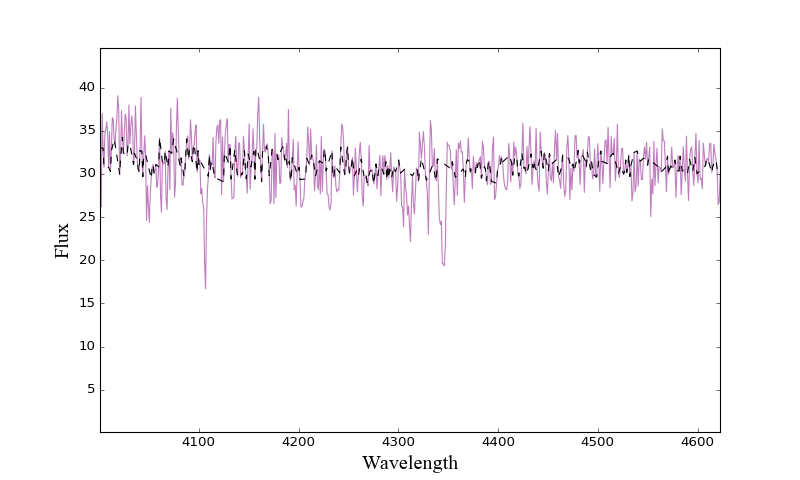

In [10]:
fig = plt.figure(figsize=(10,6))

plt.plot(Wl, Flux, color="purple", alpha=0.5)
plt.plot(WAVE, FLUX, color="black", linestyle="--")
plt.xlim([3500, 9500])
plt.xlabel("Wavelength", fontsize=18, fontname="Times New Roman")
plt.ylabel("Flux", fontsize=18, fontname="Times New Roman")
plt.show()

In [ ]:
class Spectra():
    def __init__(self, wave=[], flux=[], trim_wave=[], trim_flux=[], Continuum=[], Norm=[], Function="none"):
        self.wave = np.array(wave, dtype=np.float64)
        self.flux = np.array(flux, dtype=np.float64)
        self.trim_wave = trim_wave
        self.trim_flux = trim_flux
        self.continuum = Continuum
        self.norm_flux = Norm 
        self.Function = Function
   
    def poly_normalize(self, nlow=3.0, nhigh=3.0, boost=0.05):
        WL, FLUX = find_cont(self.wave, self.flux, nlow, nhigh)
        FLUX = FLUX + 0.05*FLUX
        self.Function = np.poly1d(np.polyfit(WL, FLUX, 4))
        self.continuum = self.Function(self.wave) # We can get error information here
        self.norm_flux = np.divide(self.flux, self.continuum)
        print "Done!"
        
    def spline_normalize(self, nlow=1.0, nhigh=5.0, BINS=25, boost=0.05, G_exclude=True):
        # Trim Spectra, bin for spline interpolation
        WL, FLUX = find_cont(self.wave, self.flux, low = nlow, high = nhigh)
    
        #Spectra = pd.DataFrame({"Wave":self.wave, "Flux":self.flux})
        Spectra = pd.DataFrame({"Wave":WL, "Flux":FLUX})
        #print "Before"
        #print len(Spectra.Wave)
        if G_exclude:
            LEFT = Spectra[(Spectra.Wave < 4200.0)]
            RIGHT = Spectra[(Spectra.Wave > 4400.0)]
            Spectra = pd.concat([LEFT, RIGHT])
        #print "-------------AFTER---------------"
        #print len(Spectra.Wave)  
        SEGMENTS = []
        
        for BIN in np.array_split(Spectra, BINS):
            #print np.average(BIN.Wave)
            SEGMENTS.append(Segment(wl=np.array(BIN.Wave), flux=np.array(BIN.Flux)))
            #print "Elements:   ",len(BIN.Wave)
        self.wl_Bin, self.flux_Bin = [], []
        
        for kernal in SEGMENTS:
            
            kernal.get_midpoint() 
            kernal.get_stats()
            self.wl_Bin.append(kernal.midpoint)
            self.flux_Bin.append(kernal.median + boost*kernal.median)
        print "Flux Bin:   ", np.average(self.flux_Bin)
        tck = interp.splrep(self.wl_Bin, self.flux_Bin,k=3,s=0.0)
        self.continuum = interp.splev(self.wave, tck)
        self.norm_flux = np.divide(self.flux, self.continuum)
        print "Spline complete"
        
        
        

In [ ]:
Wl = 10**(Spec[1].data['loglam'])
Flux = Spec[1].data['flux']

print np.average(Flux)

TEST = Spectra(wave = Wl, flux=Flux)
TEST.poly_normalize(nlow=1.0, nhigh=5.0)



In [ ]:
#fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
fig = plt.figure(figsize=(10,6))

ax1 = plt.axes([0.1, 0.6,0.9, 0.50], axisbg=[0.93,0.93,0.93])
ax2 = plt.axes([0.1, 0.1,0.9, 0.50], axisbg=[0.93,0.93,0.93],sharex=ax1)
HANDLES = [ax1, ax2]
for labels in HANDLES:
    labels.set_axisbelow(True)


ax1.plot(TEST.wave, TEST.flux, color="green", linestyle="--", alpha=0.5, zorder=3)
ax1.plot(TEST.wave, TEST.Function(TEST.wave), color="red", linestyle="--", linewidth=2.0, zorder=3)
ax1.set_ylabel("Flux", fontsize=18, fontname="Times New Roman")
ax1.set_xlim([3500,9500])
#ax1.set_ylim([0,50])
ax1.set_yticks([10,20,30,40,50])

ax2.plot(TEST.wave, TEST.norm_flux, color="black", linewidth=0.50, zorder=3, alpha=0.75)
ax2.set_xlim([3500,9500])
ax2.set_xlabel("Wavelength", fontsize=18, fontname="Times New Roman")

ax1.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

[label.spines['left'].set_visible(False) for label in HANDLES]
[label.spines['right'].set_visible(False) for label in HANDLES]

[label.grid(b=True, which='both', linewidth=2,color='1',linestyle='-', zorder=0) for label in HANDLES]
plt.show()

In [ ]:
TEST.spline_normalize()

print np.average(TEST.continuum)
fig = plt.figure(figsize=(10,6))

#plt.title("0269-51910-0353", fontsize=16)
ax1 = plt.axes([0.1, 0.6,0.9, 0.50], axisbg=[0.93,0.93,0.93])
ax2 = plt.axes([0.1, 0.1,0.9, 0.50], axisbg=[0.93,0.93,0.93],sharex=ax1)
HANDLES = [ax1, ax2]
for labels in HANDLES:
    labels.set_axisbelow(True)

ax1.set_title("0269-51910-0353")
ax1.plot(TEST.wave, TEST.flux, color="green", linestyle="-", 
         alpha=0.5, zorder=3, label="$T_{eff}$      = 5850" + "\n" + 
                                    "Log(g) = 4.434" + "\n" +
                                    "[Fe/H]  = -1.862")
ax1.plot(TEST.wave, TEST.continuum, color="red", linestyle="--", linewidth=2.0, zorder=3)
ax1.scatter(TEST.wl_Bin, TEST.flux_Bin, color="blue", marker="^")
ax1.set_ylabel("Flux", fontsize=18, fontname="Times New Roman")
ax1.set_xlim([3500,9500])
ax1.set_ylim([0,50])
ax1.set_yticks([10,20,30,40,50])
ax1.legend(framealpha=0.75, fontsize=16)

ax2.plot(TEST.wave, TEST.norm_flux, color="black", linewidth=0.50, zorder=3, alpha=0.75)
ax2.set_xlim([3500,9500])
ax2.set_xlabel("Wavelength $\AA$", fontsize=18, fontname="Times New Roman")

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax1.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

[label.spines['left'].set_visible(False) for label in HANDLES]
[label.spines['right'].set_visible(False) for label in HANDLES]

[label.grid(b=True, which='both', linewidth=2,color='1',linestyle='-', zorder=0) for label in HANDLES]
plt.show()